# Notebook for making basic PID by separating mu- and pi- based on layers traversed

In [125]:
# energy = 5
energy = 1
particle = "mu"
# particle = "pi"
scope = "primary"
# scope = "all"

In [126]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot

# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/one_sector/pi_1GeV_2k.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/one_sector/pi_1GeV_2k.edm4hep.root:events"
uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/one_sector/{particle}_{energy}GeV_2k.edm4hep.root:events"
events = up.open(uproot_path)

x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
gen_status_branch = events["MCParticles.generatorStatus"].array(library='np')
layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

In [127]:
def get_num_layers_traversed(x_pos):
    #This map contains the midpoints of each layer - each layer is 1cm in width, so we can check the 0.5cm on each side to see if a hit was in the layer
    layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]
    for layer_idx in range(len(layer_map)):
        #check if particle hit within layer
        if ((x_pos >= layer_map[layer_idx] - 5) and (x_pos <= layer_map[layer_idx] + 5)):
            return layer_idx
    #if no layers hit, send error code
    return -1

skipped 0 events


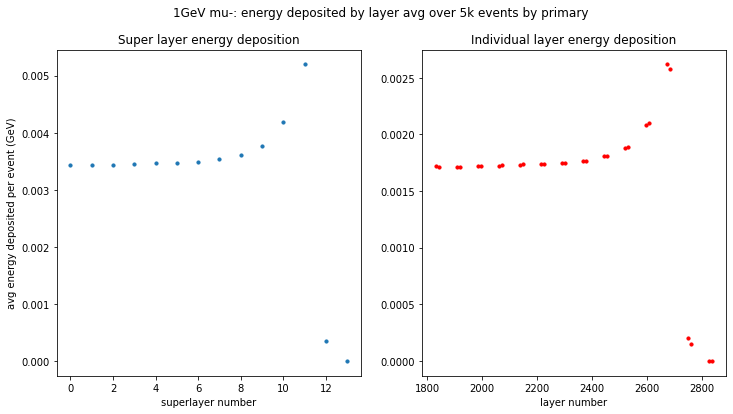

In [128]:
#### Energy deposition cut method

#initialize list that we will fill with # of layers traversed for each event
layers_traversed = []
skip_count = 0
#loop over each event
layer_EDep = np.zeros(28)

for event_idx in range(len(x_pos_branch)):
    event_x_pos = x_pos_branch[event_idx]
    event_layer_hits = []
    event_EDep = EDep_branch[event_idx]
    layer_hit_bool = np.zeros(28)
    #for each event, loop over the particles to find mu/pi
    for hit_idx in range(len(event_x_pos)):
        if(scope == "primary" and (Hits_MC_idx_branch[event_idx][hit_idx] != 0)):
            continue
        current_x_pos = event_x_pos[hit_idx]
        current_EDep = event_EDep[hit_idx]
        layer_hit = get_num_layers_traversed(current_x_pos)
#         if(layer_hit_bool[hit_idx] == 1):
#             continue
#         layer_hit_bool[hit_idx] = 1
        if(layer_hit == -1):
            skip_count += 1
            continue
        layer_EDep[layer_hit] += current_EDep
super_layer_EDep = np.zeros(14)
for i in range(len(layer_EDep)):
    super_layer_num = int(np.floor(i / 2))
    super_layer_EDep[super_layer_num] += layer_EDep[i]
super_layer_EDep = super_layer_EDep / len(x_pos_branch)
layer_EDep = layer_EDep / len(x_pos_branch)
print(f"skipped {skip_count} events")

fig,(ax1,ax2) = plot.subplots(1,2,figsize=(12,6))
fig.suptitle(f"{energy}GeV {particle}-: energy deposited by layer avg over 5k events by {scope}")
ax1.set_title("Super layer energy deposition")
ax2.set_title("Individual layer energy deposition")

ax1.set_xlabel("superlayer number")
ax2.set_xlabel("layer number")

ax1.set_ylabel("avg energy deposited per event (GeV)")
ax1.scatter(range(14),super_layer_EDep,10)
ax2.scatter(layer_map,layer_EDep,10,color = 'r',marker='o')
fig.show()
fig.savefig(f"plots/June_13/avg_event_dep/{particle}_{energy}GeV_{scope}.jpeg")

# AVG by HIT

skipped 0
skipped layer #26
skipped layer #27


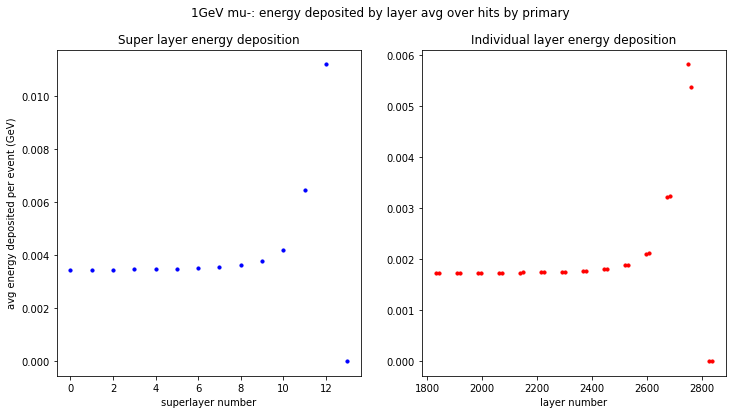

In [129]:

#### Energy deposition cut method

#initialize list that we will fill with # of layers traversed for each event
layers_traversed = []
skip_count = 0
#loop over each event
layer_EDep = np.zeros(28)
energies = [[] for i in range(28)]
energy_means = np.empty(28)
for event_idx in range(len(x_pos_branch)):
    event_x_pos = x_pos_branch[event_idx]
    event_layer_hits = []
    event_EDep = EDep_branch[event_idx]
    layer_hit_bool = np.zeros(28)
    #for each event, loop over the particles to find mu/pi
    for hit_idx in range(len(event_x_pos)):
        if(scope == "primary" and (not gen_status_branch[event_idx][Hits_MC_idx_branch[event_idx][hit_idx]])):continue
        current_x_pos = event_x_pos[hit_idx]
        current_EDep = event_EDep[hit_idx]
        layer_hit = get_num_layers_traversed(current_x_pos)
        if(layer_hit == -1):
            skip_count += 1
            continue
        energies[layer_hit].append(current_EDep)
print(f"skipped {skip_count}")
for i in range(len(energies)):
    if(len(energies[i]) == 0):
        energy_means[i] = 0
        print(f"skipped layer #{i}")
    else:
        energy_means[i] = np.mean(energies[i])
super_layer_means = np.zeros(14)
for i in range(len(layer_EDep)):
    super_layer_num = int(np.floor(i / 2))
    super_layer_means[super_layer_num] += energy_means[i]
fig,(ax1,ax2) = plot.subplots(1,2,figsize=(12,6))
fig.suptitle(f"{energy}GeV {particle}-: energy deposited by layer avg over hits by {scope}")
ax1.set_title("Super layer energy deposition")
ax2.set_title("Individual layer energy deposition")

ax1.set_xlabel("superlayer number")
ax2.set_xlabel("layer number")

ax1.set_ylabel("avg energy deposited per event (GeV)")
ax1.scatter(range(14),super_layer_means,10,color = 'b',marker='o')
ax2.scatter(layer_map,energy_means,10,color = 'r',marker='o')
fig.show()
fig.savefig(f"plots/June_13/avg_hit_dep/{particle}_{energy}GeV_{scope}.jpeg")

In [130]:
hist = [[] for i in range(28)]
generator_missed = 0
generator_hit = 0
for event_idx in range(len(x_pos_branch)):
    event_layer_hits = []
    #for each event, loop over the particles to find mu/pi
    for hit_idx in range(len(x_pos_branch[event_idx])):
        hit_position_x = x_pos_branch[event_idx][hit_idx]
        
        layer_number = -1
        hit_energy = -1
        
        MC_idx = Hits_MC_idx_branch[event_idx][hit_idx]
        if(not gen_status_branch[event_idx][MC_idx]):
            generator_missed += 1
            continue
        else:
            generator_hit += 1
        for layer_num in range(len(layer_map)):
            if((hit_position_x > (layer_map[layer_num]  - 5)) and (hit_position_x < (layer_map[layer_num]  + 5))):
                layer_number = layer_num
                break
        
        hit_energy = EDep_branch[event_idx][hit_idx]
        if(layer_number == -1):
            skip_count += 1
            continue
        hist[layer_number].append(hit_energy)
hist_means = np.empty(28)
for i in range(len(hist)):
    if(len(hist[i]) == 0):
        hist_means[i] = 0
        print(f"skipped layer #{i}")
    else:
        hist_means[i] = np.mean(hist[i])

skipped layer #26
skipped layer #27


In [48]:
print(f"generator_missed: {generator_missed} | generator_hit: {generator_hit}")

generator_missed: 171746 | generator_hit: 8502


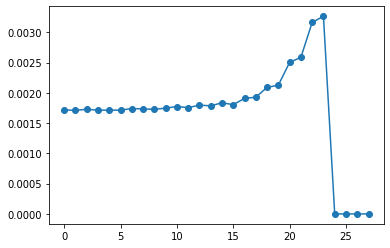

In [49]:
plot.plot(hist_means, marker="o");

In [ ]:
super_layer_EDep = np.zeros(14)
for i in range(len(layer_EDep)):
    super_layer_num = int(np.floor(i / 2))
    super_layer_EDep[super_layer_num] += layer_EDep[i]
super_layer_EDep = super_layer_EDep / len(x_pos_branch)
layer_EDep = layer_EDep / len(x_pos_branch)
print(f"skipped {skip_count} events")

fig,(ax1,ax2) = plot.subplots(1,2,figsize=(12,6))
fig.suptitle("1GeV pi-: energy deposited by layer")
ax1.set_title("Super layer energy deposition")
ax2.set_title("Individual layer energy deposition")

ax1.set_xlabel("superlayer number")
ax2.set_xlabel("layer number")

ax1.set_ylabel("avg energy deposited per event (GeV)")
ax1.scatter(range(14),super_layer_EDep,10)
ax2.scatter(layer_map,layer_EDep,10,color = 'r',marker='o')
fig.show()
# fig.savefig("plots/energy_dep/mu_1GeV_10k_edep_vs_layer_num.jpeg")